# Load our data in and take a look at both the raw data and also visualize it

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import corner
import scipy.stats as st
import scipy.optimize as so

In [2]:
silsoJD = pd.read_csv('./sunspot_data/SILSO_daily_inJD.txt', delimiter='\s+', usecols=[0,1,2,3,4], skiprows=1)

silsoJD.columns = ['JD', 'SSN', 'std', 'observations', 'definitive indicator']

In [3]:
silsoJD

,JD,SSN,std,observations,definitive indicator
0,2385070.5,-1.0,-1.0,0.0,1.0
1,2385071.5,-1.0,-1.0,0.0,1.0
2,2385072.5,-1.0,-1.0,0.0,1.0
3,2385073.5,-1.0,-1.0,0.0,1.0
4,2385074.5,-1.0,-1.0,0.0,1.0
...,...,...,...,...,...
73865,2458935.5,0.0,0.0,43.0,0.0
73866,2458936.5,0.0,0.0,39.0,0.0
73867,2458937.5,0.0,0.0,36.0,0.0
73868,2458938.5,4.0,0.2,9.0,0.0


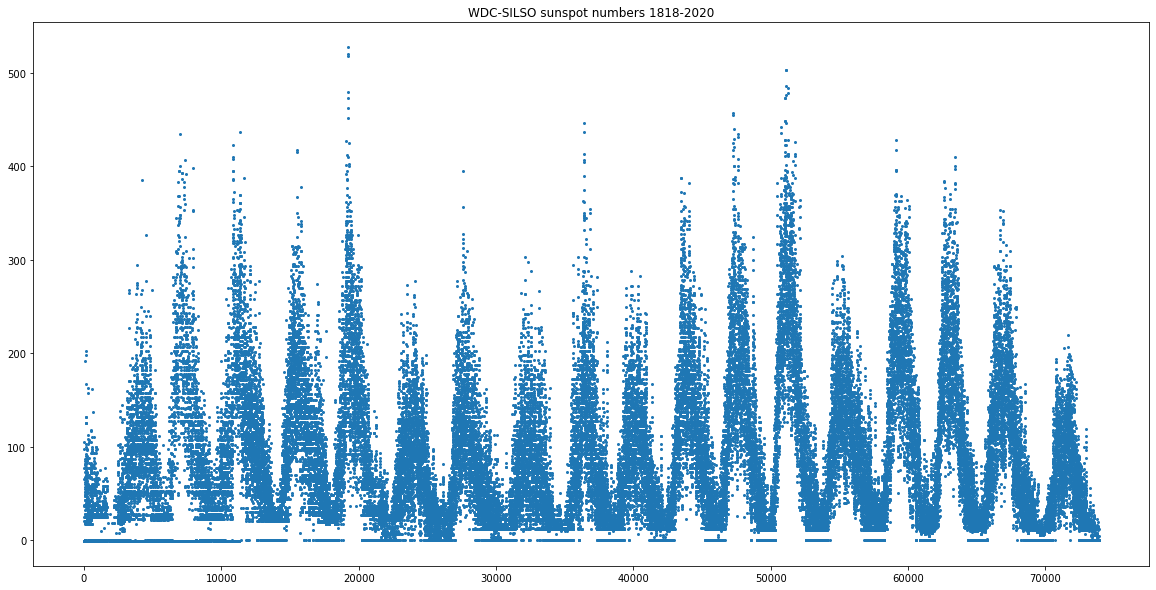

In [4]:
plt.figure(figsize=(20,10))
plt.title('WDC-SILSO sunspot numbers 1818-2020')
plt.scatter(range(len(silsoJD['SSN'])), silsoJD['SSN'], s=4)

#note: value of -1 means no data collected that day. need to cut out

## Take care of that note and clean it up, doesn't really make much of a difference but we'll be thorough anyway

In [94]:
cleaned_data = silsoJD['SSN'].replace(-1.0, 0.0)
dates = [date for date in range(len(silsoJD['SSN']))]

## Some naive guesses at what a model might look like, keep tweaking and adding sine functions until something is reasonable enough to move forward with

In [181]:
#convert to degrees for np.sin because it makes more sense in my head
dates_deg = [date*np.pi/180 for date in dates]

period1 = (len(dates)/360) / 18.33 #number of periods (in degrees) divided by how many i counted by eye 
phase1 =  np.pi - np.arcsin(0.25)  #around where the function starts (back to radians because i hate myself)
func1arg = [date/period1 + phase1 for date in dates_deg]

period2 = (len(dates)/360) / 1.75
phase2 =  np.arcsin(0.25)
func2arg = [date/period2 + phase2 for date in dates_deg]

#units are counts
amplitude1 = 180 
amplitude2 = 60

offset1 = 70
offset2 = 70

function1 = (amplitude1 * (np.sin(func1arg)) + offset1)
function2 = (amplitude2 * (np.sin(func2arg)) + offset2)

#alternative poisson counting error instead of using the included stdev?
poisson_error = pd.Series([np.sqrt(n) for n in cleaned_data])
nonzero_poisson = poisson_error.replace(0.0, 1e-20)

total_function = (function1 + function2)
total_function[total_function <0] = 0

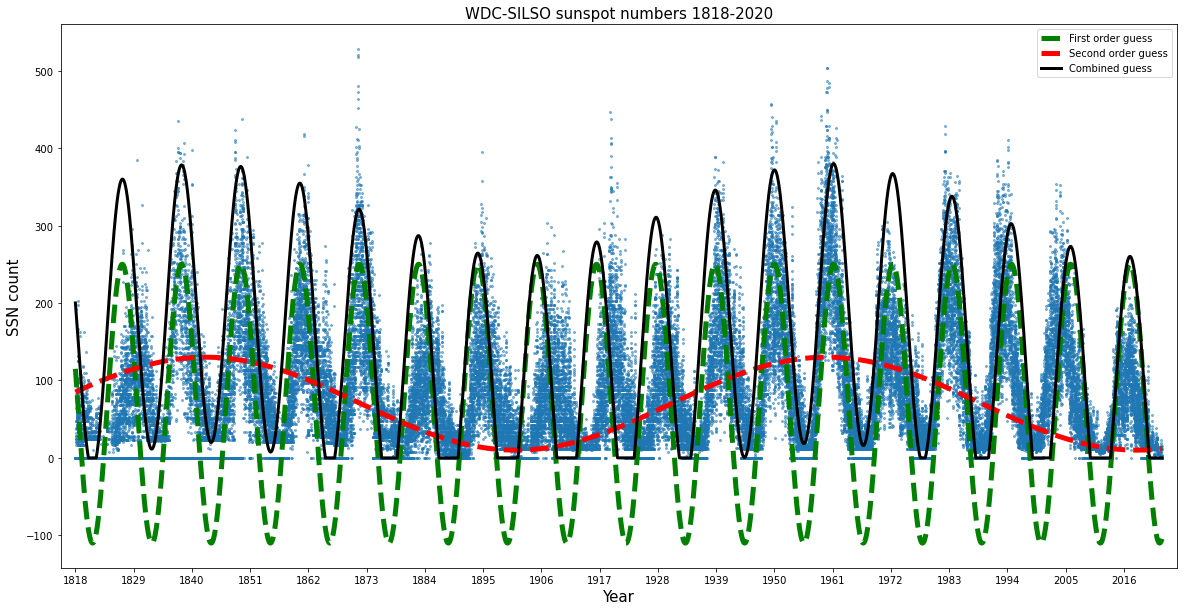

In [182]:
fig = plt.figure(figsize=(20,10))
plt.title('WDC-SILSO sunspot numbers 1818-2020', fontsize=15)
plt.ylabel('SSN count', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.xticks(np.arange(0, len(dates), 11*360), labels=np.arange(1818,2020, 11))
plt.xlim(-1000, len(dates)+1000)
plt.scatter(dates, cleaned_data, s=4, alpha=0.5)
plt.plot(dates, function1, c='g', ls='--', linewidth=5, label='First order guess')
plt.plot(dates, function2, c='r', ls='--', linewidth=5, label='Second order guess')
plt.plot(dates, total_function, c='k', linewidth=3, label='Combined guess')
plt.legend()

In [183]:
#create our model
def ssn_model(A1, B1, C1, D1, A2, B2, C2, D2, timeseries):
    arg1 = [date/B1 + C1 for date in timeseries]
    sine1 = A1 * np.sin(arg1) + D1
    arg2 = [date/B2 + C2 for date in timeseries]
    sine2 = A2 * np.sin(arg2) + D2
    combined = sine1 + sine2
#     combined[combined <0] = 0
    return combined

### Make sure our model actually looks like the manual entries above

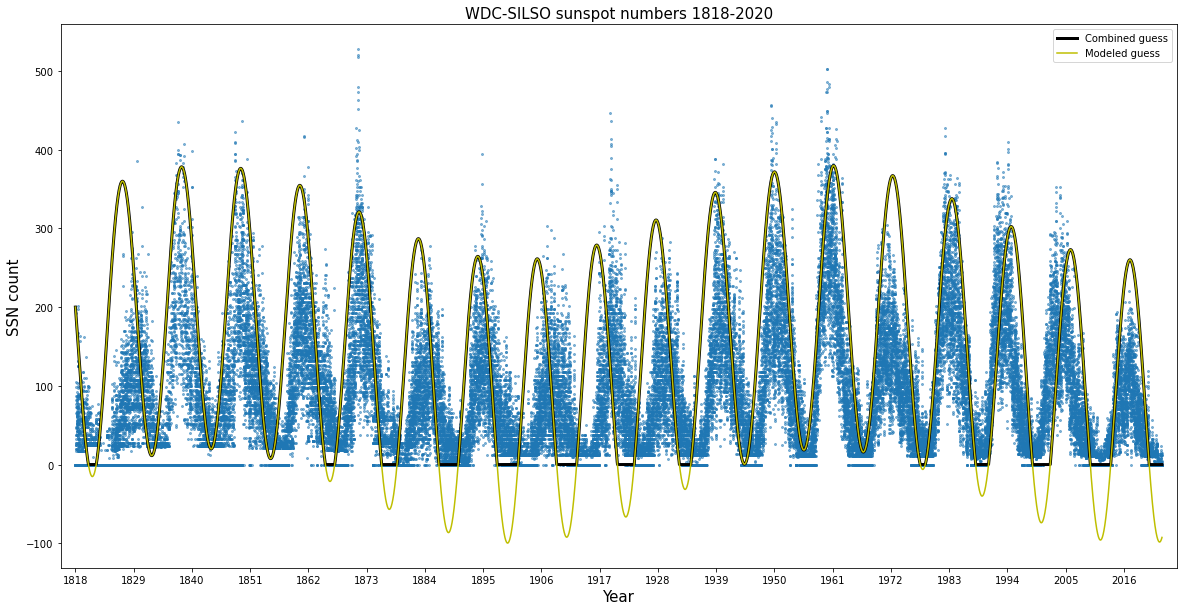

In [178]:
fig = plt.figure(figsize=(20,10))
plt.title('WDC-SILSO sunspot numbers 1818-2020', fontsize=15)
plt.ylabel('SSN count', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.xticks(np.arange(0, len(dates), 11*360), labels=np.arange(1818,2020, 11))
plt.xlim(-1000, len(dates)+1000)
plt.scatter(dates, cleaned_data, s=4, alpha=0.5)
plt.plot(dates, total_function, c='k', linewidth=3, label='Combined guess')
plt.plot(dates, ssn_model(180, (len(dates)/360) / 18.33, np.pi - np.arcsin(0.25), 70, 60, (len(dates)/360) / 1.75, np.arcsin(0.25), 70, dates_deg), c='y', label='Modeled guess')
plt.legend()

### So here's what a model for this probably looks like:

$$
SSN(t) = \left(A_1\! \sin(B_1t + C_1) + D_1\right) \ + \ \left(A_2\! \sin(B_2t + C_2) + D_2\right) \ + \ ...
$$

Where $A$ is amplitude, $B$ is period, $C$ is our phase shift, and $D$ is our displacement. For this project, we'll only focus on the 2 obvious cycles in this data: the commonly known ~11 year cycle, and what appears to be a cycle of around 115 years. Evidence suggests longer cycles such as:

- The 210 year Suess cycle
- The ~2,400 year Hallstatt cycle
- Cycles of various years including (105, 131, 232, 385, etc.)
- Unnamed cycle of possibly >6,000 years

A lot of these cycles look at radiocarbon dating, and geological observations. We're only dealing with recorded sunspot numbers from visual observations from the past 200 years so it isn't prudent to consider them for this modeling.

## That being said, now we can make a Metropolis-Hastings code to sample our functions and have that come up with a better fit...........maybe

<br>
<br>
<br>

<sub><sub>but first we'll look at how our data behaves</sub></sub>

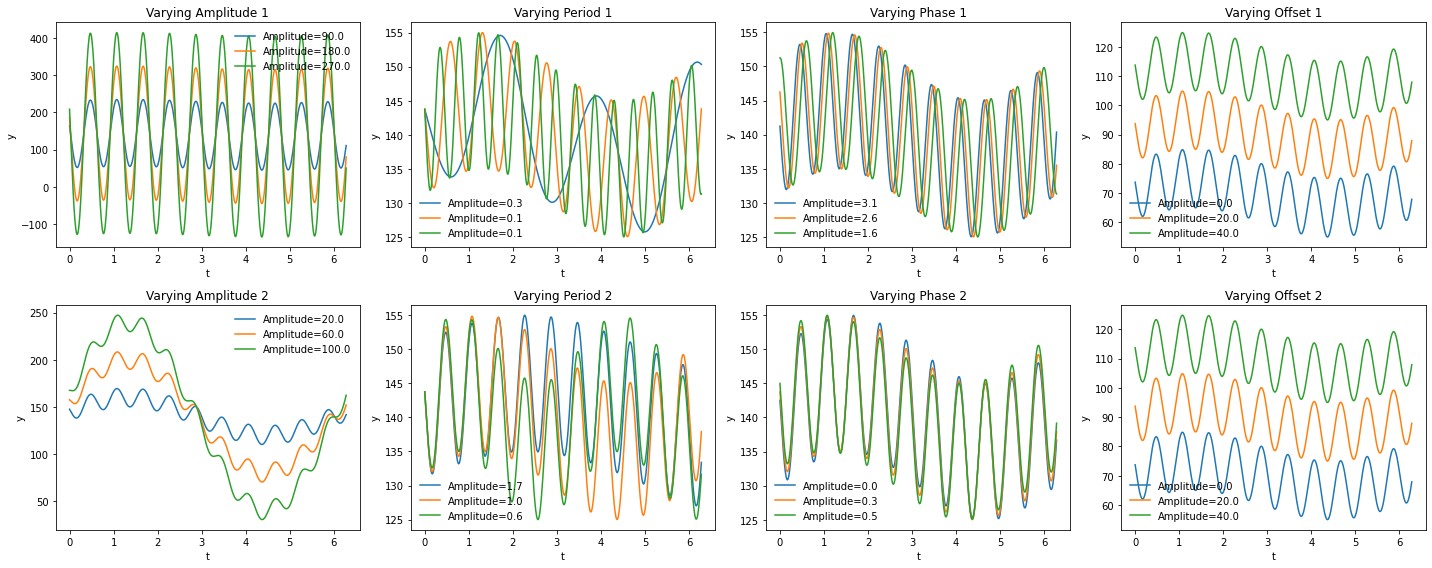

In [8]:
#for posterity's sake, we'll copy G's HW4 solution of visualizing how changing each parameter affects the overall structure
#i already spent time doing this by hand above to fine tune parameters, but this will be good to show for others
#LOOK AT YOUR DATA!

datestest = np.arange(0,2*np.pi,.01)
atest1 = 10 
atest2 = 5
btest1 = (len(datestest)/360) / 18.33 
btest2 = (len(datestest)/360) / 1.75 
ctest1 =  np.pi - np.arcsin(0.25)
ctest2 =  np.arcsin(0.25)
dtest1 = 70
dtest2 = 70

fig, axs = plt.subplots(nrows=2, ncols=4, sharex=False, figsize=(20, 8))
ax1, ax2, ax3, ax4 = axs[0]
ax5, ax6, ax7, ax8 = axs[1]

for A1x in [90, 180, 270]:
    ax1.plot(datestest, ssn_model(A1x, btest1, ctest1, dtest1, atest2, btest2, ctest2, dtest2, datestest), label=f'Amplitude={A1x:.1f}')
ax1.legend(frameon=False)
ax1.set_xlabel('t')
ax1.set_ylabel('y')
ax1.set_title('Varying Amplitude 1')

for B1x in [(len(datestest)/360)/5, (len(datestest)/360)/15, (len(datestest)/360)/25]:
    ax2.plot(datestest, ssn_model(atest1, B1x, ctest1, dtest1, atest2, btest2, ctest2, dtest2, datestest), label=f'Amplitude={B1x:.1f}')
ax2.legend(frameon=False)
ax2.set_xlabel('t')
ax2.set_ylabel('y')
ax2.set_title('Varying Period 1')

for C1x in [np.pi - np.arcsin(0), np.pi - np.arcsin(0.5), np.pi - np.arcsin(1)]:
    ax3.plot(datestest, ssn_model(atest1, btest1, C1x, dtest1, atest2, btest2, ctest2, dtest2, datestest), label=f'Amplitude={C1x:.1f}')
ax3.legend(frameon=False)
ax3.set_xlabel('t')
ax3.set_ylabel('y')
ax3.set_title('Varying Phase 1')

for D1x in [0, 20, 40]:
    ax4.plot(datestest, ssn_model(atest1, btest1, ctest1, D1x, atest2, btest2, ctest2, dtest2, datestest), label=f'Amplitude={D1x:.1f}')
ax4.legend(frameon=False)
ax4.set_xlabel('t')
ax4.set_ylabel('y')
ax4.set_title('Varying Offset 1')

for A2x in [20, 60, 100]:
    ax5.plot(datestest, ssn_model(atest1, btest1, ctest1, dtest1, A2x, btest2, ctest2, dtest2, datestest), label=f'Amplitude={A2x:.1f}')
ax5.legend(frameon=False)
ax5.set_xlabel('t')
ax5.set_ylabel('y')
ax5.set_title('Varying Amplitude 2')

for B2x in [(len(datestest)/360)/1, (len(datestest)/360)/1.75, (len(datestest)/360)/3]:
    ax6.plot(datestest, ssn_model(atest1, btest1, ctest1, dtest1, atest2, B2x, ctest2, dtest2, datestest), label=f'Amplitude={B2x:.1f}')
ax6.legend(frameon=False)
ax6.set_xlabel('t')
ax6.set_ylabel('y')
ax6.set_title('Varying Period 2')

for C2x in [np.arcsin(0), np.arcsin(0.25), np.arcsin(0.5)]:
    ax7.plot(datestest, ssn_model(atest1, btest1, ctest1, dtest1, atest2, btest2, C2x, dtest2, datestest), label=f'Amplitude={C2x:.1f}')
ax7.legend(frameon=False)
ax7.set_xlabel('t')
ax7.set_ylabel('y')
ax7.set_title('Varying Phase 2')

for D2x in [0, 20, 40]:
    ax8.plot(datestest, ssn_model(atest1, btest1, ctest1, dtest1, atest2, btest2, ctest2, D2x, datestest), label=f'Amplitude={D2x:.1f}')
ax8.legend(frameon=False)
ax8.set_xlabel('t')
ax8.set_ylabel('y')
ax8.set_title('Varying Offset 2')

fig.tight_layout()

### It's a little bit hectic there, but you can start to get the sense of what's happening overall. In the nonvaried parameters, function 1 is the smaller, faster function while function 2 is the function that takes place over a much larger period of time. Overlaying the 2 constituent sine functions might add more clarity of what's going on behind the scenes (go back to the proposed model over the actual data above), but it's also a lot more visual noise for already congested figures.

### Before we implement our _*Custom Sunspot Number M-H <sup><sup><sup>TM</sup></sup></sup>*_ we'll take a look at how scipy optimize handles this

In [184]:
# we'll define a chisq function for scipy optimize
def chisq(x, *args):
    A1, B1, C1, D1, A2, B2, C2, D2 = x
    timeseries, SSN, err = args
    model = ssn_model(A1, B1, C1, D1, A2, B2, C2, D2, timeseries)
    chisq = np.sum(((SSN - model)**2.)/(err**2.))/(len(timeseries) -4)
    return chisq
    
# and a log likelihood function for our Metropolis-Hastings implementation
def LogLikelihood(A1, B1, C1, D1, A2, B2, C2, D2, timeseries, count, err):
    x = (A1, B1, C1, D1, A2, B2, C2, D2)
    args = (timeseries, count, err)
    negLogLike = chisq(x, *args)
    return -negLogLike/2.

# we'll set some very loose bounds on each parameter
bounds = [(150,200), ((len(dates)/360) / 20, (len(dates)/360) / 15), (np.pi - np.arcsin(0.5), np.pi - np.arcsin(0)), (40, 100),
         (30,90), ((len(dates)/360) / 3, (len(dates)/360) / 1), (np.arcsin(0), np.arcsin(0.5)), (0, 100)]

# we need to pass the data to scipy.optimize
args = (dates_deg, cleaned_data, nonzero_poisson)

#restate our guess from earlier
guess = [180, (len(dates)/360) / 18.33, np.pi - np.arcsin(0.25), 70, 60, (len(dates)/360) / 1.75, np.arcsin(0.25), 70]

In [185]:
res = so.minimize(chisq, guess, args=args, bounds=bounds)
print(res)

# and we can use the Hessian inverse to set the step size for metropolis-hastings
# this choice is good because it should ensure we sample the distribution well.
sigmas = np.diag(res.hess_inv.todense())**0.5
print('Sigmas =', sigmas)

      fun: 2.205015977115456e+43
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.68723853e+41, 7.77426345e+37, 3.05617685e+40, 5.98623237e+40,
       4.65807126e+40, 4.95176016e+35, 4.59584249e+41, 5.98623237e+40])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 315
      nit: 32
   status: 0
  success: True
        x: array([150.        ,  13.44743455,   2.61799388,  40.        ,
        30.        , 177.04872922,   0.        ,   0.        ])
Sigmas = [  1.           0.59807112   4.7256989    1.           1.
 203.80783468   6.82115113   1.        ]


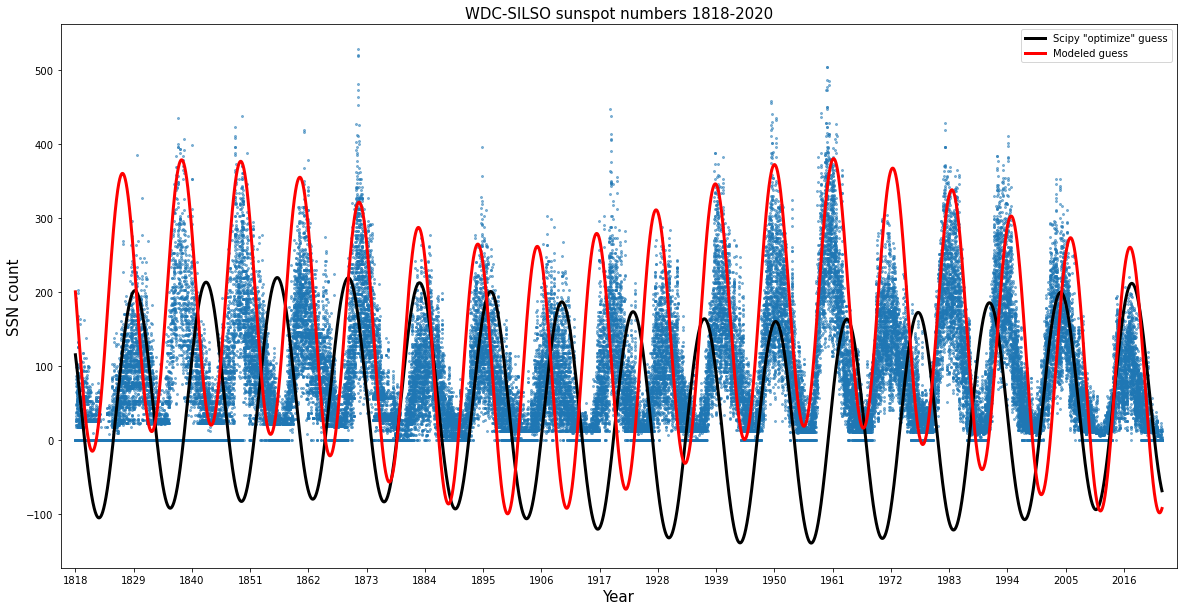

In [186]:
fig = plt.figure(figsize=(20,10))
plt.title('WDC-SILSO sunspot numbers 1818-2020', fontsize=15)
plt.ylabel('SSN count', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.xticks(np.arange(0, len(dates), 11*360), labels=np.arange(1818,2020, 11))
plt.xlim(-1000, len(dates)+1000)
plt.scatter(dates, cleaned_data, s=4, alpha=0.5)
plt.plot(dates, ssn_model(*res.x, dates_deg), c='k', linewidth=3, label='Scipy "optimize" guess')
plt.plot(dates, ssn_model(*guess, dates_deg), c='r', lw=3, label='Modeled guess')
plt.legend()

## Scipy optimize more like scipy complete garbage

## Now to begin the actual M-H

In [187]:
def logprior(A1, B1, C1, D1, A2, B2, C2, D2):
    
    #reusing our guess from earlier, hoping it works this time
    if (A1 <= 150  or A1 >= 200) or\
        (B1 <= (len(dates)/360) / 20 or B1 >= (len(dates)/360) / 15)  or\
        (C1 <= np.pi - np.arcsin(0.5) or C1 > np.pi - np.arcsin(0)) or\
        (D1 <= 40 or D1 >= 100)  or\
        (A2 <= 30 or A2 > 90) or\
        (B2 <= (len(dates)/360) / 3 or B2 >= (len(dates)/360) / 1)  or\
        (C2 <= np.arcsin(0) or C2 > np.arcsin(0.5)) or\
        (D2 <= 30 or D2 >= 90):   
        return -np.inf
    
    p_A1 = st.norm.pdf(A1, loc=1.80e2, scale=1.)
    p_B1 = st.norm.pdf(B1, loc=1.11944595e1, scale=1.)
    p_C1 = st.norm.pdf(C1, loc=2.88891239e0, scale=10.)
    p_D1 = st.norm.pdf(D1, loc=7.0e1, scale=10.)
    p_A2 = st.norm.pdf(A2, loc=6.0e1, scale=1.)
    p_B2 = st.norm.pdf(B2, loc=1.17253968e2, scale=1.)
    p_C2 = st.norm.pdf(C2, loc=2.52680255e-1, scale=10.)
    p_D2 = st.norm.pdf(D2, loc=7.0e1, scale=10.)
    
    prior = p_A1*p_B1*p_C1*p_D1*p_A2*p_B2*p_C2*p_D2
    lnprior = np.log(prior)
    
    return lnprior

def Posterior(A1, B1, C1, D1, A2, B2, C2, D2, timeseries, count, err):

    lnlike = LogLikelihood(A1, B1, C1, D1, A2, B2, C2, D2, timeseries, count, err)
    lnprior = logprior(A1, B1, C1, D1, A2, B2, C2, D2)
    lnposterior = lnlike + lnprior
    return np.exp(lnposterior)

def metropolis_hastings(p, x0, sigma, *args, nsamp=1000):
    
    ndim = len(x0)
    try:
        test_val = p(*x0, *args)
        if not np.isfinite(test_val):
            raise ValueError('Function at starting position is not finite')
        
        if test_val == 0.:
             raise ValueError('Function at starting position must be non-zero')
                
    except Exception as e:
        message = f'{e}\nCannot initialize sampler at this position'
        raise ValueError(message)
    
        
    # we need something to save the samples we want
    samples = np.zeros((nsamp, ndim))    

    x = np.array(x0)
    sigma = np.array(sigma)
    
    # the position and step size arrays had better be the same 
    assert x.shape == sigma.shape, 'Shape of x and shape of sigma must be the same'
    
    # while we want more samples
    for i in range(nsamp):

        # now we adjust the initial position a little
        # instead of explictly definition g(x|x') and g(x'|x)
        # we can recognize that a Gaussian is a stationary kernel
        # as we discussed in class, this is nice because 
        # all that matters is the absolute difference between x' and x
        # and if that's the case, then g(x'|x) = g(x|x')
        x_prime = x + sigma*np.random.randn(ndim)


        if np.random.rand() < (p(*x_prime, *args) / p(*x, *args)):
            x = x_prime
            
        # we save the sample to the chain
        samples[i] = x
    return samples

# DEBUGGING ZONE 

## alternative title: "why is this making me sad"

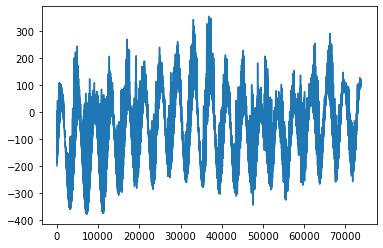

In [188]:
#difference in model vs data plot
plt.plot(dates, (cleaned_data - ssn_model(*guess, dates_deg)))

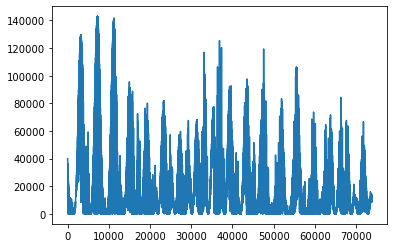

In [189]:
#chisq plot
plt.plot(dates, (cleaned_data - ssn_model(*guess, dates_deg))**2)

In [195]:
chisq(guess, *args)

4.545059489540661e+43

In [193]:
logprior(*guess)

-16.5618486376136

In [196]:
LogLikelihood(*guess, *args)

-2.2725297447703303e+43

In [199]:
Posterior(*guess, *args)

0.0

In [111]:
samples = metropolis_hastings(Posterior, guess, sigmas, *args, nsamp=100)

ValueError: Function at starting position must be non-zero
Cannot initialize sampler at this position

# Further stuff once I figure out the problem above

<ipython-input-54-228abdcad33e>:9: UserWarning: Attempting to set identical bottom == top == 180.0 results in singular transformations; automatically expanding.
  ax.set_ylim(med-3*std, med+3*std)
<ipython-input-54-228abdcad33e>:9: UserWarning: Attempting to set identical bottom == top == 70.0 results in singular transformations; automatically expanding.
  ax.set_ylim(med-3*std, med+3*std)
<ipython-input-54-228abdcad33e>:9: UserWarning: Attempting to set identical bottom == top == 60.0 results in singular transformations; automatically expanding.
  ax.set_ylim(med-3*std, med+3*std)
<ipython-input-54-228abdcad33e>:9: UserWarning: Attempting to set identical bottom == top == 0.25268025514207865 results in singular transformations; automatically expanding.
  ax.set_ylim(med-3*std, med+3*std)
<ipython-input-54-228abdcad33e>:9: UserWarning: Attempting to set identical bottom == top == 70.0 results in singular transformations; automatically expanding.
  ax.set_ylim(med-3*std, med+3*std)


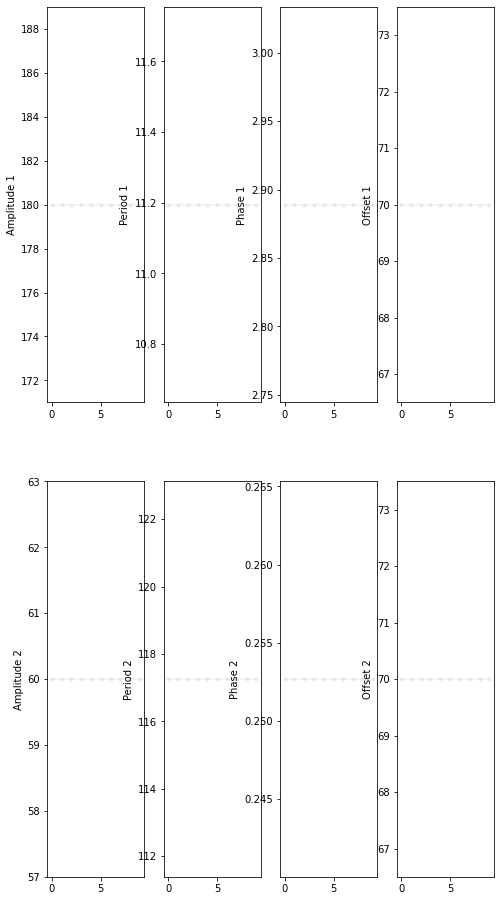

In [54]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(8, 16))
labels=['Amplitude 1', 'Period 1', 'Phase 1', 'Offset 1', 'Amplitude 2', 'Period 2', 'Phase 2', 'Offset 2']
for i in range(samples.shape[1]):
    j, k = np.unravel_index(i, (2,4))
    ax = axs[j][k]
    ax.plot(samples[::10,i], linestyle='-', color='grey', marker='.', alpha=0.1)
    med = np.median(samples[:,i])
    std = np.std(samples[:,i])
    ax.set_ylim(med-3*std, med+3*std) 
    ax.set_ylabel(labels[i])

In [58]:
fig = corner.corner(samples[10::10,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)

ValueError: It looks like the parameter(s) in column(s) 0, 1, 2, 3, 4, 5, 6, 7 have no dynamic range. Please provide a `range` argument.

Further things that could be done: (Frank attempting Fourier component analysis?)

-Refine our model. In reality, the period seems to vary from one cycle to another. Instead of it being in the form of 
$$
SSN(t) = \left(A_1\! \sin(B_1t + C_1) + D_1\right) \ + \ \left(A_2\! \sin(B_2t + C_2) + D_2\right) \ + \ ...
$$

a more accurate model might be a similar series but of finite lengths of time, instead of overarching periodic functions that last forever:

$$
SSN(t) = \left(A_1\! \sin(B_1(t_1 -t_2) + C_1) + D_1\right) \ + \ \left(A_2\! \sin(B_2(t_3-t_4) + C_2) + D_2\right) \ + \ ...
$$